In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
from matplotlib import animation
import os

from nu_nu_coll import nu_nu_collisions as coll
from BasicCode import basic_code as trunc
from MakeMovie import movie_support_functions as mv
from CollisionApprox import Collision_approx as ca

#I think this is pretty old code that was ultimately turned into MakeMovie.py

In [2]:
def make_file_list(folder_name,max_files=200,Tmin = 0.0001):
    output = []
    for i in range(max_files):
        test_name = folder_name + '/full-' + str(i)
        try:
            y_g = np.load(test_name + "-y.npy")
            if (y_g[-2][0] > Tmin):
                output.append(test_name)
            else:
                break
        except:
            break
    for i in range(max_files):
        test_name = folder_name + '/full_cont_new-' + str(i)
        try:
            y_g = np.load(test_name + "-y.npy")
            if (y_g[-2][0] > Tmin):
                output.append(test_name)
            else:
                break
        except:
            break
    return output

def make_aye(run_file):
    a_g = np.load(run_file + "-a.npy")
    y_g = np.load(run_file + "-y.npy")
    e_g = np.load(run_file + "-e.npy")
    
    y_vals = np.zeros((len(a_g),len(y_g)-3))
    t_vals = np.zeros(len(a_g))
    T_vals = np.zeros(len(a_g))
    
    for i in range(len(a_g)):
        t_vals[i] = y_g[-1][i]
        T_vals[i] = y_g[-2][i]
        for j in range(len(y_g)-3):
            y_vals[i][j] = y_g[j][i]
    
    return a_g, y_vals, e_g, T_vals, t_vals, y_g

In [3]:
def create_data_arrays(ms,mixangle,rates=False):
    folder = "../{}-{:.4}-FullTestNew/{}-{:.4}-FullTestNew".format(ms,mixangle,ms,mixangle)
    files = make_file_list(folder)
    
    a = []
    y = []
    e = []
    T = []
    t = []
    ym =[]
    Num_steps = 1
    max_y_dim = 1
    for i in range(len(files)):
        av,yv,ev,Tv,tv,ymv = make_aye(files[i])
        a.append(av)
        y.append(yv)
        e.append(ev)
        T.append(Tv)
        t.append(tv)
        ym.append(ymv)
        Num_steps += len(av) -1
        max_y_dim = max(max_y_dim, len(yv[0]))
    a_tot = np.zeros(Num_steps)
    y_tot = np.zeros((Num_steps,max_y_dim))
    e_tot = np.zeros((Num_steps,max_y_dim))
    T_tot = np.zeros(Num_steps)
    t_tot = np.zeros(Num_steps)
    y_mat = np.zeros((max_y_dim+3,Num_steps))
    
    a_tot[0] = a[0][0]
    T_tot[0] = T[0][0]
    t_tot[0] = t[0][0]

    for i in range(len(y[0][0])):
        y_tot[0][i] = y[0][0][i]
        y_mat[i][0] = y[0][0][i]
        e_tot[0][i] = e[0][i]
        
    y_mat[-1][0] = t_tot[0]
    y_mat[-2][0] = T_tot[0]

    k = 1
    for i in range(len(files)):
        print(files[i])
        for j in range(1,len(a[i])):
            a_tot[k] = a[i][j]
            T_tot[k] = T[i][j]
            t_tot[k] = t[i][j]
            y_mat[-1][k] = t_tot[k]
            y_mat[-2][k] = T_tot[k]

            for ii in range(len(e[i])):
                e_tot[k][ii] = e[i][ii]

            for ii in range(len(y[i][j])):
                y_tot[k][ii] = y[i][j][ii]
                y_mat[ii][k] = y[i][j][ii]
            k += 1
            
    if rates:
        d_tot = np.zeros((Num_steps,max_y_dim+3))
        c_tot = np.zeros((Num_steps,max_y_dim))
        k = 1
        for i in range(len(files)):
            len_e = len(np.where(e_tot[k-1] > 0)[0])+1
            A_model, n_model = ca.model_An(a_tot[k-1], T_tot[k-1], 1/(0.9 * a_tot[k-1] * T_tot[k-1]))
            print(T_tot[k-1], 1/a_tot[k-1], A_model, n_model)
            fn = mv.make_collision_fn(ms,mixangle,e_tot[k-1][:len_e],A_model,n_model)
            for j in range(1,len(a[i])):
                y_temp = np.zeros(len_e+3)
                y_temp[:len_e] = y_tot[k,:len_e]
                y_temp[-2] = T_tot[k]
                y_temp[-1] = t_tot[k]
                d, c = fn(a_tot[k],y_temp)
                d_tot[k,:len_e+3] = d
                c_tot[k,:len_e] = c
                k += 1
        np.savez(folder+'/movie-arrays',a=a_tot, y=y_tot, e=e_tot, T=T_tot, t=t_tot, ym=y_mat, d=d_tot, c=c_tot)
        return a_tot, y_tot, e_tot, T_tot, t_tot, y_mat, d_tot, c_tot
    else:
        return a_tot, y_tot, e_tot, T_tot, t_tot, y_mat

In [4]:
def make_video(mH,mixangle,mv_fn="decay_collision.mp4"):
    fn = "../{}-{:.4}-FullTestNew/{}-{:.4}-FullTestNew".format(mH,mixangle,mH,mixangle)
    movie_file_name = fn + '/' + mv_fn
    
    if not os.path.isfile(fn+'/movie-arrays.npz'):
        print("Need to create data arrays.  Will take a few minutes.")
        create_data_arrays(mH,mixangle,True)
    arrs = np.load(fn+'/movie-arrays.npz')
    
    hbar = 6.58212e-22
    tH = trunc.tH(mH,mixangle)*hbar
    

    fig = plt.figure(figsize=(10,8))
    ax1 = plt.axes([0.09,0.1,0.415,0.42])
    ax0 = plt.axes([0.09,0.52,0.415,0.42])
    ax2 = plt.axes([0.65,0.25,0.3,0.5])
#    ics, = ax0.loglog([], [], linewidth=2, linestyle='--',color='0.50')
#    e_thermal, = ax0.loglog([], [], linewidth=2, linestyle='--',color='0.75')
    nu, = ax0.loglog([], [], linewidth=3, color='b')
    ax0.set_ylim([1e-10,10])
    ax0.set_yticks([1e-9,1e-6,1e-3,1e0])
    ax0.set_xlim([0.5,3000])
    ax1.set_xlim([0.5,3000])
    ax0.set_ylabel(r"$\epsilon^3 \, f(\epsilon)$")
    ax0.set_title("{} MeV, {:.3} s decay lifetime".format(mH,tH))
    ax0.xaxis.set_major_formatter(plt.NullFormatter())
    
    d_rate, = ax1.loglog([], [], linewidth=2, color='k')
    c_ratep, = ax1.loglog([], [], linewidth=2, color='k', linestyle='--')
    c_ratem, = ax1.loglog([], [], linewidth=2, color='r', linestyle='--')
#    cel_ratep, = ax1.loglog([], [], linewidth=2, color='k', linestyle=':')
#    cel_ratem, = ax1.loglog([], [], linewidth=2, color='r', linestyle=':')
    ax1.set_ylim([1e-25,1e4])
    ax1.set_yticks([1e-25,1e-20,1e-15,1e-10,1e-5,1e0])
    ax1.set_xlabel(r"$\epsilon = E_\nu / T_{cm}$")
    ax1.set_ylabel(r"Rate ($df/da$)")

    ax2.set_xlim(15,.015)
    ax2.set_ylim(.0015,15)
    ax2.set_ylabel(r"$T$ (MeV)")
    ax2.set_xlabel(r"$T_{cm}$ (MeV)")
    temp_temp, = ax2.loglog([], [], linewidth=2, color = 'k')
    diag, = ax2.loglog([], [], color='0.75', linestyle=':')
    time_text = ax2.text(10,3e-3,"",fontsize=12)
    
    
    def init():
#        ics.set_data([], [])
#        e_thermal.set_data([], [])
        nu.set_data([], [])
        d_rate.set_data([], [])
        c_ratep.set_data([], [])
        c_ratem.set_data([], [])
#        cel_ratep.set_data([],[])
#        cel_ratem.set_data([],[])
        temp_temp.set_data([],[])
        diag.set_data([],[])
        time_text.set_text("")
        return nu, d_rate, c_ratep, c_ratem, time_text, temp_temp, diag
#        return ics, e_thermal, nu, d_rate, c_ratep, c_ratem, cel_ratep, cel_ratem, time_text, temp_temp, diag
    
    def animate(i):
        e_vec = arrs['e'][i,:]
        y_vec = arrs['y'][i,:]
        d_vec = arrs['d'][i,:]
        c_vec = arrs['c'][i,:]
        T = arrs['T'][i]
        t = arrs['t'][i]
        a = arrs['a'][i]
        a_vec = arrs['a'][:(i+1)]
        T_vec = arrs['T'][:(i+1)]
        len_e = len(np.where(e_vec > 0)[0])+1

        eps = e_vec[:len_e]
        yv = y_vec[:len_e]
        d = d_vec[:len_e]
        c = c_vec[:len_e]

#        ics.set_data(eps,eps**3 / (np.exp(eps) + 1) / (2 * np.pi**3))
#        e_thermal.set_data(eps, eps**3 / (np.exp(eps / T[i] / a[i]) +1) / (2 * np.pi**3))
        nu.set_data(eps, eps**3 * yv / (2 * np.pi**3))
        d_rate.set_data(eps,d)
        c_ratep.set_data(eps,c)
        c_ratem.set_data(eps,-c)
#        cel_ratep.set_data(e[i][:-1],cel[i][:-1])
#        cel_ratem.set_data(e[i][:-1],-cel[i][:-1])
        time_text.set_text(r"$T = $"+"{:8.3} MeV".format(T) + '\n\n' + "$T_{cm} = $"+"{:8.3} MeV".format(1/a) + '\n' + "t = {:10.3} s".format(t * hbar))
        temp_temp.set_data(1/a_vec,T_vec)
        diag.set_data(np.linspace(0.001,20),np.linspace(0.001,20))
        
        return nu, d_rate, c_ratep, c_ratem, time_text, temp_temp, diag
#        return ics, e_thermal, nu, d_rate, c_ratep, c_ratem, cel_ratep, cel_ratem, time_text, temp_temp, diag
    
    anim = animation.FuncAnimation(fig, animate, init_func = init, frames = len(arrs['a']), interval = 1, blit=True)
    
    anim.save(fn)



In [5]:
%time a, y, e, T, t, ym, d, c = create_data_arrays(300,7e-5,True)

300-7e-05-FullTestNew/full-0
300-7e-05-FullTestNew/full-1
300-7e-05-FullTestNew/full-2
300-7e-05-FullTestNew/full-3
300-7e-05-FullTestNew/full-4
300-7e-05-FullTestNew/full-5
300-7e-05-FullTestNew/full-6
300-7e-05-FullTestNew/full_cont_new-0
300-7e-05-FullTestNew/full_cont_new-1
300-7e-05-FullTestNew/full_cont_new-2
300-7e-05-FullTestNew/full_cont_new-3
300-7e-05-FullTestNew/full_cont_new-4
300-7e-05-FullTestNew/full_cont_new-5
300-7e-05-FullTestNew/full_cont_new-6
300-7e-05-FullTestNew/full_cont_new-7
300-7e-05-FullTestNew/full_cont_new-8
300-7e-05-FullTestNew/full_cont_new-9
300-7e-05-FullTestNew/full_cont_new-10
300-7e-05-FullTestNew/full_cont_new-11
300-7e-05-FullTestNew/full_cont_new-12
14.873650530203944 14.871507118843985 0.9672986084490427 0.9435265362248363
7.665882146711377 7.435753559421992 0.9699557072211505 0.945079973506341
6.04532821980879 5.71092698412379 0.9722090549518582 0.9464761867422375
5.27607495959055 4.886983499386997 0.9738351326334174 0.9475083715334308
4.6320

/Users/nu_mu/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


0.001610057794303052 0.0009765625 -0.4243257710234434 2.2828039123386077
CPU times: user 1h 12min 27s, sys: 19min 12s, total: 1h 31min 39s
Wall time: 9min 44s


ValueError: Invalid file object: <_io.BufferedReader name=69>

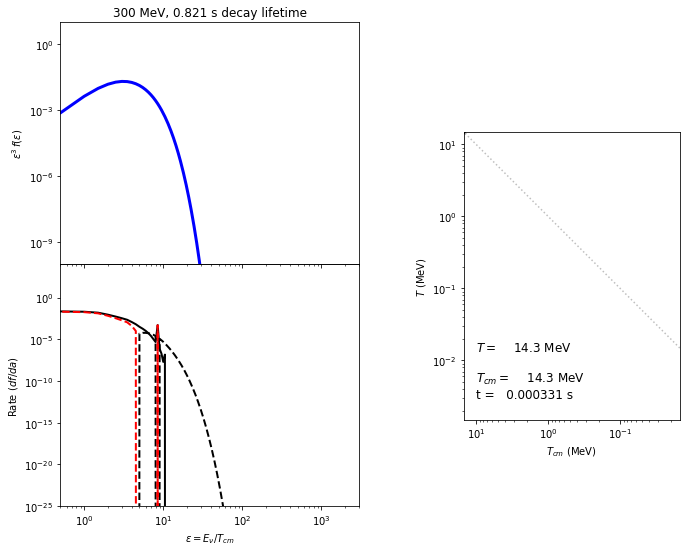

In [6]:
make_video(300,1.35e-5,"decay_video.mp4")

In [ ]:
np.savez('300-7e-05-FullTestNew/movie-arrays',a=a, y=y, e=e, T=T, t=t, ym=ym, d=d, c=c)

In [ ]:
e.shape

In [ ]:
a, y, e, T, t, ym = create_data_arrays(300,7e-5,False)

In [ ]:
a.shape

In [ ]:
len_e = len(np.where(e[10] > 0)[0])+1
fn= mv.make_collision_fn(300,7e-5,e[10][:len_e],1,1)
y_temp = np.zeros(len_e+3)
y_temp[:len_e] = y[10,:len_e]
y_temp[-2] = T[10]
y_temp[-1] = t[10]


In [ ]:
d, c = fn(a[10],y_temp)

In [ ]:
c

In [ ]:
a, y, e, T, t, ym = create_data_arrays(300,10.0,False)

In [ ]:
f_SM = e[-1]**3/(2*np.pi**2) / (np.exp(e[-1]/a[-1] / (T[-1] * (4/11)**(1/3))))
plt.figure(figsize=(6,4.5))
plt.loglog(e[-1],y[-1]*e[-1]**3/(2*np.pi**2),color='k',linewidth=2)
plt.loglog(e[-1],f_SM,linestyle='--')
plt.xlabel(r'$\epsilon = p_\nu / T_{\rm cm}$',fontsize=14)
plt.ylabel(r'$\epsilon^3 \,f(\epsilon)$',fontsize=14)
plt.ylim(1e-6,4)
plt.xlim(0.5,250)
#plt.savefig('spectrum.pdf')
plt.show()

In [ ]:
ma = [4, 6, 7, 8, 0.9, 3, 2, 1.2, 1, 0.8, 1.35, 1.25]
ne = [2.7, 2.95, 3.00, 3.02, 4.09, 2.50, 2.58, 3.69, 3.96, 4.31, 2.91, 3.61]

In [ ]:
tau = []
for mix in ma:
    tau.append(trunc.tH(300,mix*1e-5)*6.58e-22)

In [ ]:
tau

In [ ]:
plt.figure(figsize=(6,4.5))
plt.semilogx(tau,ne,'ok')
plt.xlabel(r'$\tau$ (s)',fontsize=14)
plt.ylabel(r'$N_{\rm eff}$',fontsize=14)
#plt.savefig('Neff.pdf')
plt.show()

In [ ]:
import MakeMovie as mv

In [ ]:
mv.make_video(300,7e-5)

In [ ]:
ma = np.load("300-7e-05-FullTestNew/movie-arrays.npz")

In [ ]:
ma.files

In [ ]:
ma['np_SM']

In [ ]:
ma['np']/ma['np_SM']